In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix, brier_score_loss, roc_curve, roc_auc_score, multilabel_confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from datetime import datetime, timedelta
from docx2python import docx2python
from imblearn.over_sampling import SMOTE


# Part 1: Data Manipulation

This section will read the data from the relevant files and create clean dataframes ready for input into any ML model.

In [2]:
#Import data

raw_df = pd.read_csv('SRS_all_2001-2020_2.csv')
raw_flares = pd.read_csv('flare_list_2.csv')
Monthly_Sunspots = pd.read_csv('SN_m_tot_V2.0.csv')

In [3]:
#Drop duplicate flares. This sorts the flares by class alphabetically and keeps the last value, so if both classes of flare occur the X occurence is retained.

raw_flares.sort_values('goes_class_ind')
raw_flares.drop_duplicates(subset=['ID'], inplace=True, keep='last')
raw_flares.reset_index(inplace=True)

In [4]:
#This merges the sunspot dataframe with the flare dataframe, matching on the ID (formed in Excel) representing date and location.

merged_df = pd.merge(raw_df[['ID','Area','Z','Mag Type','Number of Sunspots','date']], raw_flares[['ID','goes_class_ind']], 
                     on = 'ID', 
                     how='left')

#Replace any N/As with 0

merged_df = merged_df.fillna(0)

In [5]:
#This creates a column for just the month that the sunspot occurred in.

merged_df['Month'] = pd.to_datetime(merged_df['date'], format='%d/%m/%Y')
merged_df['Month'] = merged_df.Month.dt.to_period('M').dt.to_timestamp()

#This creates a month column in the sunspot monthly averages dataframe, ready for merging.

Monthly_Sunspots['Date'] = pd.to_datetime(Monthly_Sunspots[['Year', 'Month']].assign(DAY=1))
Monthly_Sunspots.drop('Month', axis=1, inplace=True)
Monthly_Sunspots.rename(columns={'Date':'Month'}, inplace=True)

#We merge the sunspot/flare dataframe with the monthly average dataframe to add the monthly average feature.

merged_df = pd.merge(merged_df[['ID', 'Area', 'Z', 'Mag Type', 'Number of Sunspots', 'date', 'goes_class_ind', 'Month']],
                     Monthly_Sunspots[['Month', 'Average']],
                     on = 'Month',
                     how = 'left')

In [6]:
#We need to remove all events from 2016 and 2017 in order to avoid information leak when we test on the SRS data for these years.

start_remove = datetime(2016,1,1)
end_remove = datetime(2017,12,31)

merged_df = merged_df.loc[(merged_df.Month < start_remove) | (merged_df.Month > end_remove)]



In [7]:
#Split McIntosh parameter into its constituent parts
merged_df['Z-value'] = merged_df['Z'].str[0]
merged_df['p-value'] = merged_df['Z'].str[1]
merged_df['c-value'] = merged_df['Z'].str[2]

#Create binary flare and class columns
merged_df['X_Class'] = [1 if x == 'X' else 0 for x in merged_df['goes_class_ind']]
merged_df['Binary_Flare'] = [1 if x == 'M' or x == 'X' else 0 for x in merged_df['goes_class_ind']]

#Rename and drop columns as appropriate
merged_df.rename(columns={'Number of Sunspots':'Number_of_Sunspots'}, inplace=True)
merged_df.rename(columns={'Mag Type':'Mag_Type'}, inplace=True)

merged_df.drop('Z', axis=1, inplace=True)
merged_df.drop('goes_class_ind', axis=1, inplace=True)


In [8]:
#We need to remove all non-occurences where a flare without a location has occurred in the following 24 hours
#We can use the raw flares list, comparing the full ID to the last 5 digits - all should have the full number of digits as the SRS data does.

merged_df['ID_str'] = merged_df['ID'].astype(str)
merged_df['ID_str'] = merged_df['ID_str'].str[-5:]
merged_df['ID_str'] = merged_df['ID_str'].astype(int)

raw_flares = raw_flares.fillna(0)
raw_flares['ID2'] = raw_flares['ID'].astype(int)

#Merge lists based on this new ID, which matches every event with a flare on that day if there was one
merged_df = pd.merge(merged_df, raw_flares[['ID2']], 
                     left_on = 'ID_str',
                     right_on = 'ID2', 
                     how='left')

#Drop all non-flares that now have an entry in the new ID column (i.e. they have an unlocated flare on the same day)
merged_df = merged_df.drop(merged_df[(merged_df.Binary_Flare == 0) & (merged_df.ID2 > 0)].index)

#Finally, remove temporary ID columns
merged_df.drop('ID_str', axis=1, inplace=True)
merged_df.drop('ID2', axis=1, inplace=True)

In [9]:
#Define dictionaries for encoding

Z_values = {'A' : 0.1, 'H' : 0.15, 'B' : 0.3, 'C' : 0.45, 'D' : 0.6, 'E' : 0.75, 'F' : 0.9}
p_values = {'x' : 0, 'r' : 0.1, 's' : 0.3, 'a' : 0.5, 'h' : 0.7, 'k' : 0.9}
c_values = {'x' : 0, 'o' : 0.1, 'i' : 0.5, 'c' : 0.9}
Mag_values = {'Alpha' : 0, 'Beta' : 0.1, 'Gamma' : 0.4, 'Gamma-Delta' : 0.5, 'Beta-Gamma' : 0.3, 'Beta-Delta' : 0.6, 'Beta-Gamma-Delta' : 0.9,
                'Beta-Gamma.' : 0.3, 'Beta-gamma' : 0.3, 'Beta-delta' : 0.6}

#Map dataframe dictionary values

merged_df['Z-value'] = merged_df['Z-value'].map(Z_values)
merged_df['c-value'] = merged_df['c-value'].map(c_values)
merged_df['p-value'] = merged_df['p-value'].map(p_values)
merged_df['Mag_Type'] = merged_df['Mag_Type'].map(Mag_values)
                

In [10]:
#Need to remove all events after 15/05/2019 as that is where our flare data goes up to.

row = merged_df[merged_df['ID'] == 1274143604].index.tolist()[0]
merged_df = merged_df.loc[:row]

In [11]:
#At this point it is worth checking the numbers of positive and negative datapoints in our final dataframe.

neg, pos = np.bincount(merged_df['Binary_Flare'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 21839
    Positive: 898 (4.11% of total)



# Part 2: Initial Training and Testing

Having arrived at a merged and cleaned dataframe containing all the feature information required, we can carry out initial basic training and testing on some machine learning models.



In [ ]:
#Create copy of dataframe and remove any columns/features that we don't want to include. Uncomment column heading to remove the named features.

cleaned_df = merged_df.copy()

cleaned_df.pop('ID')
cleaned_df.pop('X_Class')
cleaned_df.pop('date')
cleaned_df.pop('Month')
#cleaned_df.pop('Average')
#cleaned_df.pop('Mag_Type')
#cleaned_df.pop('Number_of_Sunspots')
#cleaned_df.pop('Area')
#cleaned_df.pop('Z-value')
#cleaned_df.pop('p-value')
#cleaned_df.pop('c-value')

In [164]:
#This uses a utility from sklearn to split and shuffle the dataset. To test on NOAA data the test size is set to 0.2
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)

#Features are scaled and arrays formed for input into ML models.

scaler = StandardScaler()

train_labels = np.array(train_df.pop('Binary_Flare'))
test_labels = np.array(test_df.pop('Binary_Flare'))

train_features = np.array(train_df)
test_features = np.array(test_df)

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


In [123]:
#Over-sampling. Define the re-sampling size and create new classes.

rs_count = 6

Neg_resample = np.bincount(train_labels)[0]
Pos_resample = rs_count*np.bincount(train_labels)[1]

Class_rebalance = {0:Neg_resample, 1:Pos_resample}

oversample = SMOTE(sampling_strategy=Class_rebalance)

os_train_features, os_train_labels = oversample.fit_resample(train_features, train_labels)


In [14]:
#ALTERNATIVE: Run if using whole dataset as training

train_df = cleaned_df
scaler = StandardScaler()
train_labels = np.array(train_df.pop('Binary_Flare'))
train_features = np.array(train_df)
train_features = scaler.fit_transform(train_features)


In [165]:
#Define models and fit to training data.

MLP_Model = MLPClassifier()                             #(hidden_layer_sizes = (300,), activation='tanh', alpha=0.00001)
RF_Model = RandomForestClassifier()                     #(n_estimators=120, criterion='entropy')
Log_Model = LogisticRegression()

MLP_Model.fit(train_features, train_labels)
RF_Model.fit(train_features, train_labels)
Log_Model.fit(train_features, train_labels)

LogisticRegression()

In [ ]:
#ALTERNATIVE: Fit models to over-sampled data

MLP_Model.fit(os_train_features, os_train_labels)
RF_Model.fit(os_train_features, os_train_labels)
Log_Model.fit(os_train_features, os_train_labels)

In [166]:
#Define TensorFlow deep learning model. Input shape must be number of features included

model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(2)
])

In [167]:
#Compile TensorFlow model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              )

In [168]:
#Fit TensorFlow model to training data. Number of epochs can be altered

model.fit(train_features, train_labels, epochs=20, verbose=0)

In [128]:
#ALTERNATIVE: Fit TensorFlow model to over-sample training data.

model.fit(os_train_features, os_train_labels, epochs=20, verbose=0)

In [169]:
#Create probabilistic predictions for TensorFlow model.

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [170]:
#Use only positive predictions.

predictions = probability_model.predict(test_features)

predictions = [x[1] for x in predictions]


In [171]:
#Create probabilistic predictions for test dataset.

MLP_Proba = MLP_Model.predict_proba(test_features)
RF_Proba = RF_Model.predict_proba(test_features)
Log_Proba = Log_Model.predict_proba(test_features)

#Take the positive probabilities (i.e. the flaring probabilities) for use in performance measurement.

MLP_Proba_Pos = [element[1] for element in MLP_Proba]
RF_Proba_Pos = [element[1] for element in RF_Proba]
Log_Proba_Pos = [element[1] for element in Log_Proba]

In [172]:
#Create binary flare/no-flare lists for use in binary performance metrics

MLP_bin = [0 if x < 0.5 else 1 for x in MLP_Proba_Pos]
RF_bin = [0 if x < 0.5 else 1 for x in RF_Proba_Pos]
Log_bin = [0 if x < 0.5 else 1 for x in Log_Proba_Pos]
TF_bin = [0 if x < 0.5 else 1 for x in predictions]

In [173]:
#Print Brier, AUC, precision and recall scores.

print('Multi-layer Perceptron: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(brier_score_loss(test_labels, MLP_Proba_Pos), round(roc_auc_score(test_labels, MLP_Proba_Pos),4), round(precision_score(test_labels, MLP_bin),4), round(recall_score(test_labels, MLP_bin),4)))

print('Random Forest: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(brier_score_loss(test_labels, RF_Proba_Pos), round(roc_auc_score(test_labels, RF_Proba_Pos),4), round(precision_score(test_labels, RF_bin),4), round(recall_score(test_labels, RF_bin),4)))

print('Logistic Regression: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(brier_score_loss(test_labels, Log_Proba_Pos), round(roc_auc_score(test_labels, Log_Proba_Pos),4), round(precision_score(test_labels, Log_bin),4), round(recall_score(test_labels, Log_bin),4)))

print('Deep Learning: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(brier_score_loss(test_labels, predictions), round(roc_auc_score(test_labels, predictions),4), round(precision_score(test_labels, TF_bin),4), round(recall_score(test_labels, TF_bin),4)))

Multi-layer Perceptron: Brier Score 0.030208433654249175; ROC-AUC Score 0.8806; Precision 0.6154; Recall 0.1395

Random Forest: Brier Score 0.033359585613539876; ROC-AUC Score 0.8446; Precision 0.459; Recall 0.1628

Logistic Regression: Brier Score 0.03120272274721283; ROC-AUC Score 0.8675; Precision 0.4783; Recall 0.1919

Deep Learning: Brier Score 0.032757381454843984; ROC-AUC Score 0.8805; Precision 0.4602; Recall 0.3023



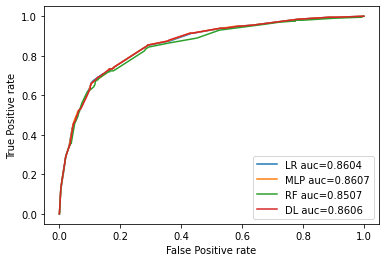

In [23]:
#Code to produce ROC curves of the above results.

plt.figure(0).clf()

fpr, tpr, thresh = roc_curve(test_labels, Log_Proba_Pos)
auc = roc_auc_score(test_labels, Log_Proba_Pos)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="LR auc="+str(auc))

fpr, tpr, thresh = roc_curve(test_labels, MLP_Proba_Pos)
auc = roc_auc_score(test_labels, MLP_Proba_Pos)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="MLP auc="+str(auc))

fpr, tpr, thresh = roc_curve(test_labels, RF_Proba_Pos)
auc = roc_auc_score(test_labels, RF_Proba_Pos)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="RF auc="+str(auc))

fpr, tpr, thresh = roc_curve(test_labels, predictions)
auc = roc_auc_score(test_labels, predictions)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="DL auc="+str(auc))

plt.legend(loc=0)

plt.ylabel('True Positive rate')
plt.xlabel('False Positive rate')

plt.savefig('NEW_Area_NOAA_ROC')

In [34]:
#Confusion matrix plotter if required.

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  

In [ ]:
#Plot confusion matrix for a result if required.

plot_cm(np.array(test_labels), np.array(Log_Proba_Pos))

# Part 3: Hyperparameter Optimisation

Having seen some initial results on the NOAA dataset with default parameters, we can attempt to improve the performance scores by running some sort of hyperparameter optimisation procedure.

DO NOT RUN this section, grid search methods such as this are very slow. It has been run once to establish the optimal hyperparameters. 

In [ ]:
#Create pipeline and set of hyperparameters to search over.

MLP_pipe = Pipeline([('scaler', StandardScaler()),
                     ('mlpclassifier', MLPClassifier())])

params = [{'mlpclassifier__hidden_layer_sizes': [(100,), (50,100,50), (200,), (300,), (10,20,10), (50,50)],
          'mlpclassifier__activation' : ['tanh', 'relu'],
          'mlpclassifier__solver' : ['adam', 'lbfgs', 'sgd'],
          'mlpclassifier__alpha' : [0.0001, 0.001, 0.01, 0.00001] }]

gs_MLP = GridSearchCV(MLP_pipe, param_grid=params, scoring='neg_brier_score', cv=5)

#Fit to training data, and list best parameters of the ones given

gs_MLP.fit(train_features, train_labels)
gs_MLP.best_params_


In [ ]:
#Optimisation for random forest works in exactly the same way.

RF_pipe = Pipeline([('scaler', StandardScaler()),
                     ('clf', RandomForestClassifier())])

params = [{'clf__n_estimators': [50, 100, 150, 200, 250],
          'clf__criterion' : ['gini', 'entropy'],
          'clf__max_features' : ['auto', 'sqrt', 'log2'] }]

gs_RF = GridSearchCV(RF_pipe, param_grid=params, scoring='neg_brier_score', cv=5)

gs_RF.fit(train_features, train_labels)
gs_RF.best_params_


# Part 4: Multi-label Classification

Before moving on to the main SRS data testing, we can have an attempt at multi-label classification on the NOAA data.

In [14]:
#Create copy of dataframe

multicopy_df = merged_df.copy()

#The lines below create classes 0, 1 and 2. This is because multi-label over-sampling is not supported in Python. In order to achieve this we need to create multi-class classifications, then oversample, then re-label as multi-label classes [0,0], [1,0] and [1,1].

multicopy_df.loc[(multicopy_df.Binary_Flare == 1), 'Multi_class'] = 1
multicopy_df.loc[(multicopy_df.X_Class == 1), 'Multi_class'] = 2
multicopy_df.loc[(multicopy_df.Binary_Flare == 0), 'Multi_class'] = 0

multicopy_df.rename(columns={'Binary_Flare':'M_Class'}, inplace=True)


In [ ]:
#Remove unwanted columns. Uncomment to remove additional features

multicopy_df.pop('ID')
multicopy_df.pop('date')
multicopy_df.pop('Month')
#cleaned_df.pop('Average')
#cleaned_df.pop('Mag_Type')
#cleaned_df.pop('Number_of_Sunspots')
#cleaned_df.pop('Z-value')
#cleaned_df.pop('p-value')
#cleaned_df.pop('c-value')

In [107]:
#Create a further copy for re-sampling analysis.

multi_class_df = multicopy_df.copy()

In [108]:
#Split second copy into training and testing datasets.

rs_train_df, rs_test_df = train_test_split(multi_class_df, test_size=0.2)

In [ ]:
#Remove unnecessary columns.

rs_train_df.pop('X_Class')
rs_train_df.pop('M_Class')

In [110]:
#Rebalance training data such that the number of M and X class flares are equal. Number of non-flaring datapoints remains the same.

Neg_resample = np.bincount(rs_train_df)[0]
M_resample = np.bincount(rs_train_df)[1]

Class_rebalance = {0:Neg_resample, 1:M_resample, 2:M_resample}

#Creates oversampled vectors X and y.

oversample = SMOTE(sampling_strategy=Class_rebalance)

y = rs_train_df.pop('Multi_class')
X = rs_train_df

X, y = oversample.fit_resample(X, y)

In [113]:
#Define dataframe for scatter plot.

M_scatter_df = X[X.M_Class != 0]
X_scatter_df = M_scatter_df[M_scatter_df.X_Class == 1]
M_scatter_df = M_scatter_df[M_scatter_df.X_Class == 0]


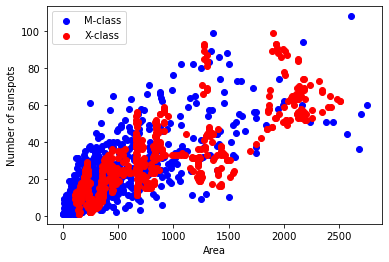

In [115]:
#This creates scatter plot of area and number of sunspots. Can be easily altered to show different features. Option to save image.

plt.scatter(M_scatter_df['Area'], M_scatter_df['Number_of_Sunspots'], color='blue', label='M-class')
plt.scatter(X_scatter_df['Area'], X_scatter_df['Number_of_Sunspots'], color='red', label='X-class')
plt.legend(loc="upper left")
plt.ylabel('Number of sunspots')
plt.xlabel('Area')

#plt.savefig('...')

plt.show()

In [ ]:
#We need to return to the original multi-label classification now that the process of re-sampling is complete.

X['Multi_Class'] = y

X.loc[(X.Multi_Class == 1), 'M_Class'] = 1
X.loc[(X.Multi_Class == 2), 'M_Class'] = 1
X.loc[(X.Multi_Class == 0), 'M_Class'] = 0

X.loc[(X.Multi_Class == 2), 'X_Class'] = 1
X.loc[(X.Multi_Class == 1), 'X_Class'] = 0
X.loc[(X.Multi_Class == 0), 'X_Class'] = 0

X.pop('Multi_Class')



In [87]:
#This then creates the 2-dimensional multi-label target vectors.

rs_train_labels = np.vstack((X.pop('M_Class'), X.pop('X_Class'))).T
rs_test_labels = np.vstack((rs_test_df.pop('M_Class'), rs_test_df.pop('X_Class'))).T

#This vector is now redundant.

rs_test_df.pop('Multi_class')

In [95]:
#Scale features, and define arrays for input into model

scaler = StandardScaler()

train_features = np.array(X)
test_features = np.array(rs_test_df)

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [ ]:
#Create model and fit to over-sample data.

model = MLPClassifier()

multi_model = MultiOutputClassifier(model)

multi_model.fit(train_features, rs_train_labels)

In [97]:
#Make binary and probabilistic predictions.

multi_pred = multi_model.predict(test_features)
multi_pred_proba = multi_model.predict_proba(test_features)

In [98]:
#We can use built-in functionality for an unformatted view of how effective predictions are. Can also use other metrics for each matrix if required.
#The top array represents M-class predictions, and the bottom X-class

multilabel_confusion_matrix(rs_test_labels, multi_pred)

array([[[4139,   48],
        [ 129,   52]],

       [[4325,   32],
        [   9,    2]]], dtype=int64)

In [19]:
#Now return to original dataframe without re-sampling.

#This creates the target vectors based on whether there is no flare, M-class or X-class.

multi_train_df, multi_test_df = train_test_split(multicopy_df, test_size=0.2)

multi_train_labels = np.vstack((multi_train_df.pop('M_Class'), multi_train_df.pop('X_Class'))).T
multi_test_labels = np.vstack((multi_test_df.pop('M_Class'), multi_test_df.pop('X_Class'))).T



In [38]:
#Scale features, and define arrays for input into model

scaler = StandardScaler()

train_features = np.array(multi_train_df)
test_features = np.array(multi_test_df)

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [ ]:
#Define model as below, or RandomForestClassifier() or LogisticRegression()

model = MLPClassifier()

multi_model = MultiOutputClassifier(model)

multi_model.fit(train_features, multi_train_labels)

In [43]:
#Make binary and probabilistic predictions.

multi_pred = multi_model.predict(test_features)
multi_pred_proba = multi_model.predict_proba(test_features)

In [44]:
#Define individual lists of M and X-class flare predictions

M_pred = [x[0] for x in multi_pred]
X_pred = [x[1] for x in multi_pred]

M_pred_proba = [x[1] for x in multi_pred_proba[0]]
X_pred_proba = [x[1] for x in multi_pred_proba[1]]

M_labels = [x[0] for x in multi_test_labels]
X_labels = [x[1] for x in multi_test_labels]


In [45]:
#Print results.

print('M-Class: Brier Score {}; ROC-AUC Score {} \n'.format(brier_score_loss(M_labels, M_pred_proba), roc_auc_score(M_labels, M_pred_proba)))
print('X-Class: Brier Score {}; ROC-AUC Score {} \n'.format(brier_score_loss(X_labels, X_pred_proba), roc_auc_score(X_labels, X_pred_proba)))


M-Class: Brier Score 0.03293296037571136; ROC-AUC Score 0.893120737045709 

X-Class: Brier Score 0.0021598757543268834; ROC-AUC Score 0.9798531436438733 



In [46]:
#We can also have a simple visualisation of a confusion matrix.

multilabel_confusion_matrix(multi_test_labels, multi_pred)

array([[[4152,   28],
        [ 156,   32]],

       [[4358,    0],
        [  10,    0]]], dtype=int64)

In [47]:
#Create vectors for plotting.

M_df = multicopy_df[multicopy_df['M_Class'] == 1]
X_df = multicopy_df[multicopy_df['X_Class'] == 1]

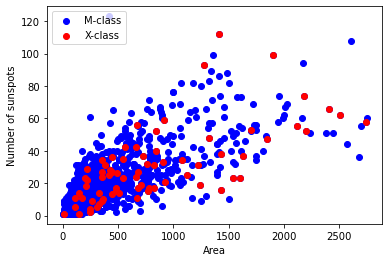

In [48]:
#This creates scatter plot of area and number of sunspots. Can be easily altered to show different features. Option to save image.

plt.scatter(M_df['Area'], M_df['Number_of_Sunspots'], color='blue', label='M-class')
plt.scatter(X_df['Area'], X_df['Number_of_Sunspots'], color='red', label='X-class')
plt.legend(loc="upper left")
plt.ylabel('Number of sunspots')
plt.xlabel('Area')

#plt.savefig('...')

plt.show()

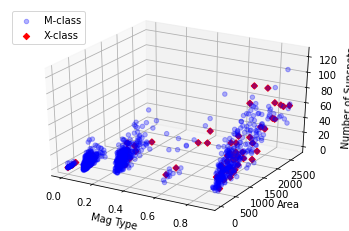

In [49]:
#Similarly, we have code to produce a 3D scatter plot with three different features.

fig = plt.figure()

ax = fig.add_subplot(111,projection='3d')

ax.scatter(M_df['Mag_Type'], M_df['Area'], M_df['Number_of_Sunspots'], color='blue', label='M-class', zorder=-1, alpha=0.3)

ax.scatter(X_df['Mag_Type'], X_df['Area'], X_df['Number_of_Sunspots'],  color='red', label='X-class', marker='D', zorder=1, alpha=1)

plt.legend(loc="upper left")

ax.set_ylabel('Area')
ax.set_xlabel('Mag Type')
ax.set_zlabel('Number of Sunspots')

#plt.savefig('...')

plt.show()


# Part 5: SRS Data Manipulation

In order to make and test predictions on the SRS data, we need to write a significant amount of code to obtain appropriate dataframes from the given docx files.

In [22]:
#First, set the root directory containing docx files (can be in any number of subfolders)
rootdir = 'C:/Users/david/Desktop/Docx_Data'

#Next we need to create a dataframe where each sunspot from each docx file is transformed into a row with each attribute a column entry. This uses the very useful docx2python package, which would need installing.
df_list = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        df = pd.DataFrame(docx2python(os.path.join(subdir, file)).body[1])
        M_Issued_value = df.iloc[-1,2][0]
        M_Raw_value = df.iloc[-2,2][0]
        X_Issued_value = df.iloc[-1,3][0]
        X_Raw_value = df.iloc[-2,3][0]
        df['M_Issued'] = M_Issued_value
        df['M_Raw'] = M_Raw_value
        df['X_Issued'] = X_Issued_value
        df['X_Raw'] = X_Raw_value
        df = df.iloc[1:,:]
        df = df.iloc[:-2,:]
        df['DateTime'] = os.path.basename(file)[42:52].replace("-", "", 2) + os.path.basename(file)[37:41]
        df_list.append(df)

SRS_df = pd.concat(df_list)

In [23]:
#A quick visualisation is useful to see what we are working with.

SRS_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,M_Issued,M_Raw,X_Issued,X_Raw,DateTime
1,[2473],[S21W61],[334],[210],[Cao],[16.0],[14],[Beta-Gamma],[Decrease],[3],[0],[0],20,3,1,0,201601010200
1,[2473],[S20W75],[335],[60],[Cao],[12],[5],[Beta],[Decrease],[3],[0],[1],30,15,1,1,201601020200
2,[2476],[S11E61],[199],[10],[Bxi],[3],[5],[Beta],[Increase],[6],[0],[1],30,15,1,1,201601020200
3,[2477],[N12E74],[186],[100],[Hhx],[3],[1],[Alpha],[Nil],[6],[1],[1],30,15,1,1,201601020200
4,[24xx],[S08E81],[179],[5],[Axx],[1],[1],[Alpha],[N/A],[1],[0],[0],30,15,1,1,201601020200


In [24]:
#Rename columns and drop unnecessary ones
SRS_df.columns = ['No', 'Loc', 'Lo', 'Area', 'Z', 'LL', 'NN', 'Mag_Type', 'Growth', 'M', 'X', 'P', 'M_Issued', 'M_Raw', 'X_Issued', 'X_Raw', 'DateTime']

SRS_df.drop('Loc', axis=1, inplace=True)
SRS_df.drop('Lo', axis=1, inplace=True)
SRS_df.drop('LL', axis=1, inplace=True)
SRS_df.drop('Growth', axis=1, inplace=True)
SRS_df.drop('P', axis=1, inplace=True)

#We can see that each entry is formatted as a list. This can be easily rectified by mapping a function to the dataframe.
def unlist(x):
    if isinstance(x, list):
        return x[0]
    else:
        return x

SRS_df = SRS_df.applymap(unlist)

#Now remove any un-located entries (as we can't definitively say whether these flared or not)

SRS_df['No'].replace('', np.nan, inplace=True)
SRS_df.dropna(subset=['No'], inplace=True)


In [25]:
#The main challenge with this task is matching sunspots to flares.

#First create two functions which create datetime objects in the same format, based on the two different date/time formats we have in the sunspot and flare dataframes.
def StartDateTime(x):
    y = datetime(int(x[0:4]), int(x[4:6]), int(x[6:8]), int(x[8:10]))
    return(y)

def StartDateTime2(x):
    y = datetime(int(x[6:10]), int(x[3:5]), int(x[0:2]), int(x[11:13]))
    return(y)

SRS_df['DateTime'] = SRS_df['DateTime'].map(StartDateTime)
raw_flares['event_starttime'] = raw_flares['event_starttime'].map(StartDateTime2)

#This then ensures the sunspot numbers are in the same format in both dataframes.
raw_flares['noaa_ar'] = raw_flares['noaa_ar'].astype(int)
raw_flares['noaa_ar'] = raw_flares['noaa_ar'].astype(str)
raw_flares['noaa_ar'] = raw_flares['noaa_ar'].str[1:]

In [ ]:
#This code uses the timedelta functionality of the datetime module to assign a binary 1 to sunspots that occur in the same location as flares in the preceding 24 hours.

#The code is not ideal as it is slow and generates a dataframe warning, however this does not have a negative impact on functionality, and it matches sunspots to flares correctly.

SRS_df['Binary_Flare'] = ''
for row in range(len(SRS_df['DateTime'])):
    if any(SRS_df['No'].iloc[row] == raw_flares['noaa_ar'].iloc[x] and SRS_df['DateTime'].iloc[row] < raw_flares['event_starttime'].iloc[x] < SRS_df['DateTime'].iloc[row] + timedelta(days = 1) for x in range(len(raw_flares['noaa_ar']))):
        SRS_df['Binary_Flare'].iloc[row] = 1
    else:
        SRS_df['Binary_Flare'].iloc[row] = 0



In [27]:
#Now that flares have been matched to sunspots, we can carry out the same encoding procedure as in part 3.

#Split Z parameter and delete old column
SRS_df['Z-value'] = SRS_df['Z'].str[0]
SRS_df['p-value'] = SRS_df['Z'].str[1]
SRS_df['c-value'] = SRS_df['Z'].str[2]

#Encode
SRS_df['Z-value'] = SRS_df['Z-value'].map(Z_values)
SRS_df['c-value'] = SRS_df['c-value'].map(c_values)
SRS_df['p-value'] = SRS_df['p-value'].map(p_values)
SRS_df['Mag_Type'] = SRS_df['Mag_Type'].map(Mag_values)

SRS_df = SRS_df.dropna()

In [28]:
#Now fix some formatting issues with non-numerical characters.

SRS_df = SRS_df[SRS_df['Area'] != '?']
SRS_df = SRS_df[SRS_df['Area'] != '-']
SRS_df['Area'] = SRS_df['Area'].map(lambda x: x.lstrip('~>').rstrip('*'))

SRS_df['Area'] = SRS_df['Area'].astype(float)
SRS_df['NN'] = SRS_df['NN'].astype(float)



In [29]:
#Create Month parameter for matching with monthly average.
SRS_df['Month'] = SRS_df.DateTime.dt.to_period('M').dt.to_timestamp()

#Merge dataframe with monthly average sunspot dataframe to add this feature.
SRS_df = pd.merge(SRS_df[['No', 'Area', 'Z', 'NN', 'Mag_Type', 'Binary_Flare', 'Z-value', 'p-value', 'c-value', 'Month', 'M', 'X', 'M_Issued', 'M_Raw', 'X_Issued', 'X_Raw', 'DateTime']],
                     Monthly_Sunspots[['Month', 'Average']],
                     on = 'Month',
                     how = 'left')

In [30]:
#Fix formatting for MOSWOC M and X class predictions.

SRS_df['M'] = SRS_df['M'].replace('',0)
SRS_df['M'] = SRS_df['M'].replace('N/A',0)
SRS_df['M'] = SRS_df['M'].astype(float)/100

SRS_df['X'] = SRS_df['X'].replace('',0)
SRS_df['X'] = SRS_df['X'].replace('N/A',0)
SRS_df['X'] = SRS_df['X'].astype(float)/100

#Define total combined probability of EITHER an M or X class flare for an individual sunspot, as predicted by MOSWOC.

SRS_df['MOSWOC'] = 1 - (1 - SRS_df['M'])*(1 - SRS_df['X'])


In [31]:
#Fix formatting of issued and raw forecasts for combined periods. We are left with each sunspot row in our dataframe having a column entry representing the combined MOSWOC issued and raw forecasts for that period.

SRS_df['M_Issued'] = SRS_df['M_Issued'].replace('',0)
SRS_df['M_Raw'] = SRS_df['M_Raw'].replace('',0)
SRS_df['M_Issued'] = SRS_df['M_Issued'].astype(float)/100
SRS_df['M_Raw'] = SRS_df['M_Raw'].astype(float)/100

SRS_df['X_Issued'] = SRS_df['X_Issued'].replace('',0)
SRS_df['X_Raw'] = SRS_df['X_Raw'].replace('',0)
SRS_df['X_Issued'] = SRS_df['X_Issued'].astype(float)/100
SRS_df['X_Raw'] = SRS_df['X_Raw'].astype(float)/100

#Define total issued and raw probabilities for EITHER and M or X-class flare for an amalgamated period, as predicted by MOSWOC.

SRS_df['Issued'] = 1 - (1 - SRS_df['M_Issued'])*(1 - SRS_df['X_Issued'])
SRS_df['Raw'] = 1 - (1 - SRS_df['M_Raw'])*(1 - SRS_df['X_Raw'])

In [32]:
#It is worth observing again how the dataframe looks after this data manipulation.

SRS_df.head()

,No,Area,Z,NN,Mag_Type,Binary_Flare,Z-value,p-value,c-value,Month,...,X,M_Issued,M_Raw,X_Issued,X_Raw,DateTime,Average,MOSWOC,Issued,Raw
0,2473,210.0,Cao,14.0,0.3,1,0.45,0.5,0.1,2016-01-01,...,0.00,0.2,0.03,0.01,0.00,2016-01-01 02:00:00,57.0,0.0300,0.208,0.0300
1,2473,60.0,Cao,5.0,0.1,0,0.45,0.5,0.1,2016-01-01,...,0.00,0.3,0.15,0.01,0.01,2016-01-02 02:00:00,57.0,0.0300,0.307,0.1585
2,2476,10.0,Bxi,5.0,0.1,0,0.30,0.0,0.5,2016-01-01,...,0.00,0.3,0.15,0.01,0.01,2016-01-02 02:00:00,57.0,0.0600,0.307,0.1585
3,2477,100.0,Hhx,1.0,0.0,0,0.15,0.7,0.0,2016-01-01,...,0.01,0.3,0.15,0.01,0.01,2016-01-02 02:00:00,57.0,0.0694,0.307,0.1585
4,24xx,5.0,Axx,1.0,0.0,0,0.10,0.0,0.0,2016-01-01,...,0.00,0.3,0.15,0.01,0.01,2016-01-02 02:00:00,57.0,0.0100,0.307,0.1585


# Part 6: Testing on SRS Data (individual active regions)

We are now ready to test our models on the cleaned and formatted SRS dataframe. First we test on individual sunspots against the raw predictions.

In [182]:
#This makes a copy of our SRS dataframe, creates a MOSWOC prediction list, a list of class labels, and an array with the final features.

cleaned_SRS = SRS_df.copy()

MOSWOC_pred = SRS_df['MOSWOC'].tolist()

SRS_labels = SRS_df['Binary_Flare'].tolist()

cleaned_SRS = cleaned_SRS[['Area', 'Mag_Type', 'NN', 'Average','Z-value', 'p-value', 'c-value']] #Add or remove features here as required (Average between NN and Z-value) 'Area', 'Mag_Type', 'NN', 'Average', ((((BEFORE McIntosh))))

SRS_features = np.array(cleaned_SRS)
SRS_features = scaler.transform(SRS_features)

In [183]:
#Make predictions from previously trained models, define positive and negative prediction lists.

SRS_MLP_Proba = MLP_Model.predict_proba(SRS_features)
SRS_RF_Proba = RF_Model.predict_proba(SRS_features)
SRS_Log_Proba = Log_Model.predict_proba(SRS_features)
SRS_TF = probability_model.predict(SRS_features)

SRS_MLP_Proba_Pos = [element[1] for element in SRS_MLP_Proba]
SRS_RF_Proba_Pos = [element[1] for element in SRS_RF_Proba]
SRS_Log_Proba_Pos = [element[1] for element in SRS_Log_Proba]
SRS_TF_Pos = [element[1] for element in SRS_TF]

SRS_MLP_Proba_Neg = [element[0] for element in SRS_MLP_Proba]
SRS_RF_Proba_Neg = [element[0] for element in SRS_RF_Proba]
SRS_Log_Proba_Neg = [element[0] for element in SRS_Log_Proba]
SRS_TF_Neg = [element[0] for element in SRS_TF]


In [184]:
#Create binary flare/no-flare lists for use in binary performance metrics

SRS_MLP_bin = [0 if x < 0.5 else 1 for x in SRS_MLP_Proba_Pos]
SRS_RF_bin = [0 if x < 0.5 else 1 for x in SRS_RF_Proba_Pos]
SRS_Log_bin = [0 if x < 0.5 else 1 for x in SRS_Log_Proba_Pos]
MOSWOC_bin = [0 if x < 0.5 else 1 for x in MOSWOC_pred]
SRS_TF_bin = [0 if x < 0.5 else 1 for x in SRS_TF_Pos]

In [49]:
print('Multi-layer Perceptron: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(SRS_labels, SRS_MLP_Proba_Pos),4), round(roc_auc_score(SRS_labels, SRS_MLP_Proba_Pos),4), round(precision_score(SRS_labels, SRS_MLP_bin),4), round(recall_score(SRS_labels, SRS_MLP_bin),4)))

print('Random Forest: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(SRS_labels, SRS_RF_Proba_Pos),4), round(roc_auc_score(SRS_labels, SRS_RF_Proba_Pos),4), round(precision_score(SRS_labels, SRS_RF_bin),4), round(recall_score(SRS_labels, SRS_RF_bin),4)))

print('Logistic Regression: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(SRS_labels, SRS_Log_Proba_Pos),4), round(roc_auc_score(SRS_labels, SRS_Log_Proba_Pos),4), round(precision_score(SRS_labels, SRS_Log_bin),4), round(recall_score(SRS_labels, SRS_Log_bin),4)))

print('Deep Learning: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(SRS_labels, SRS_TF_Pos),4), round(roc_auc_score(SRS_labels, SRS_TF_Pos),4), round(precision_score(SRS_labels, SRS_TF_bin),4), round(recall_score(SRS_labels, SRS_TF_bin),4)))

print('MOSWOC Raw: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(SRS_labels, MOSWOC_pred),4), round(roc_auc_score(SRS_labels, MOSWOC_pred),4), round(precision_score(SRS_labels, MOSWOC_bin),4), round(recall_score(SRS_labels, MOSWOC_bin),4)))

Multi-layer Perceptron: Brier Score 0.0123; ROC-AUC Score 0.9471; Precision 0.5116; Recall 0.2857

Random Forest: Brier Score 0.0138; ROC-AUC Score 0.9131; Precision 0.5676; Recall 0.2727

Logistic Regression: Brier Score 0.0115; ROC-AUC Score 0.9551; Precision 0.7273; Recall 0.1039

Deep Learning: Brier Score 0.0115; ROC-AUC Score 0.9442; Precision 0.8; Recall 0.0519

MOSWOC Raw: Brier Score 0.0164; ROC-AUC Score 0.9257; Precision 0.2535; Recall 0.2338



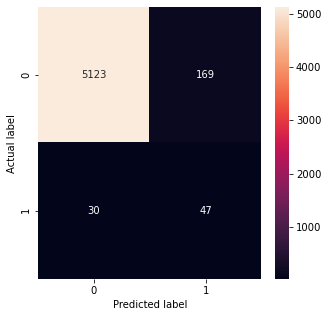

In [125]:
plot_cm(np.array(SRS_labels), np.array(SRS_Log_Proba_Pos))

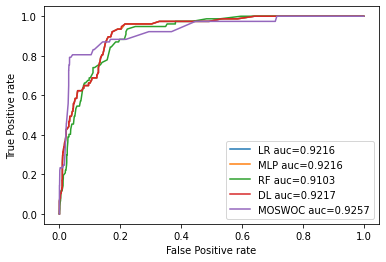

In [109]:
#Plot ROC curves again if desired.

plt.figure(0).clf()

fpr, tpr, thresh = roc_curve(SRS_labels, SRS_Log_Proba_Pos)
auc = roc_auc_score(SRS_labels, SRS_Log_Proba_Pos)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="LR auc="+str(auc))

fpr, tpr, thresh = roc_curve(SRS_labels, SRS_MLP_Proba_Pos)
auc = roc_auc_score(SRS_labels, SRS_MLP_Proba_Pos)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="MLP auc="+str(auc))

fpr, tpr, thresh = roc_curve(SRS_labels, SRS_RF_Proba_Pos)
auc = roc_auc_score(SRS_labels, SRS_RF_Proba_Pos)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="RF auc="+str(auc))

fpr, tpr, thresh = roc_curve(SRS_labels, SRS_TF_Pos)
auc = roc_auc_score(SRS_labels, SRS_TF_Pos)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="DL auc="+str(auc))

fpr, tpr, thresh = roc_curve(SRS_labels, MOSWOC_pred)
auc = roc_auc_score(SRS_labels, MOSWOC_pred)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="MOSWOC auc="+str(auc))


plt.legend(loc=0)

plt.ylabel('True Positive rate')
plt.xlabel('False Positive rate')

plt.savefig('NEW_Individual_Area_ROC')

plt.show()

# Part 7: Testing on SRS Data (combined active regions)

Now that we have calculated probabilities for every active region, we can implement a procedure to combine these probabilities so we can compare results with MOSWOC raw and issued forecasts.

In [185]:
#First we add the negative flaring prediction probabilites to the original SRS dataframe and create a new copy.

SRS_df['MLP_neg_prediction'] = SRS_MLP_Proba_Neg
SRS_df['RF_neg_prediction'] = SRS_RF_Proba_Neg
SRS_df['Log_neg_prediction'] = SRS_Log_Proba_Neg
SRS_df['TF_neg_prediction'] = SRS_TF_Neg


SRS_day = SRS_df.copy()

In [186]:
#Next we can use dataframe functionality to group entries by certain criteria - in this case the date and time. Note that we are taking the product of the negative predictions, the sum of the binary predictions, and the mean of the raw and issued forecasts. The product of the neg predictions is what we need, the rest is just to include these in the new dataframe.

SRS_day = SRS_day.groupby('DateTime').apply(lambda s: pd.Series({ 
    'Cumul_MLP_neg_prediction': s['MLP_neg_prediction'].prod(), 
    'Cumul_RF_neg_prediction': s['RF_neg_prediction'].prod(), 
    'Cumul_Log_neg_prediction': s['Log_neg_prediction'].prod(), 
    'Cumul_TF_neg_prediction': s['TF_neg_prediction'].prod(), 
    'Binary_Sum': s['Binary_Flare'].sum(),
    'Raw': s['Raw'].mean(),
    'Issued': s['Issued'].mean()
    }))

#Return to binary representation
SRS_day.loc[SRS_day.Binary_Sum > 1, 'Binary_Sum'] = 1

#Now we can calculate the cumulative positive prediction from the cumulative negative prediction
SRS_day['Cumul_MLP_pos_prediction'] = 1 - SRS_day['Cumul_MLP_neg_prediction'] 
SRS_day['Cumul_RF_pos_prediction'] = 1 - SRS_day['Cumul_RF_neg_prediction'] 
SRS_day['Cumul_Log_pos_prediction'] = 1 - SRS_day['Cumul_Log_neg_prediction'] 
SRS_day['Cumul_TF_pos_prediction'] = 1 - SRS_day['Cumul_TF_neg_prediction'] 

#Create arrays for final cumulative day probability prediction and class labels
Final_MLP_pred = np.array(SRS_day['Cumul_MLP_pos_prediction'])
Final_RF_pred = np.array(SRS_day['Cumul_RF_pos_prediction'])
Final_Log_pred = np.array(SRS_day['Cumul_Log_pos_prediction'])
Final_TF_pred = np.array(SRS_day['Cumul_TF_pos_prediction'])


Class_labels = np.array(SRS_day['Binary_Sum'])
Raw_pred = np.array(SRS_day['Raw'])
Issued_pred = np.array(SRS_day['Issued'])

In [187]:
#Create binary flare/no-flare lists for use in binary performance metrics

Final_MLP_bin = [0 if x < 0.5 else 1 for x in Final_MLP_pred]
Final_RF_bin = [0 if x < 0.5 else 1 for x in Final_RF_pred]
Final_Log_bin = [0 if x < 0.5 else 1 for x in Final_Log_pred]
Final_TF_bin = [0 if x < 0.5 else 1 for x in Final_TF_pred]
Raw_bin = [0 if x < 0.5 else 1 for x in Raw_pred]
Issued_bin = [0 if x < 0.5 else 1 for x in Issued_pred]

In [121]:
print('Multi-layer Perceptron: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(Class_labels, Final_MLP_pred),4), round(roc_auc_score(Class_labels, Final_MLP_pred),4), round(precision_score(Class_labels, Final_MLP_bin),4), round(recall_score(Class_labels, Final_MLP_bin),4)))

print('Random Forest: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(Class_labels, Final_RF_pred),4), round(roc_auc_score(Class_labels, Final_RF_pred),4), round(precision_score(Class_labels, Final_RF_bin),4), round(recall_score(Class_labels, Final_RF_bin),4)))

print('Logistic Regression: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(Class_labels, Final_Log_pred),4), round(roc_auc_score(Class_labels, Final_Log_pred),4), round(precision_score(Class_labels, Final_Log_bin),4), round(recall_score(Class_labels, Final_Log_bin),4)))

print('Deep Learning: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(Class_labels, Final_TF_pred),4), round(roc_auc_score(Class_labels, Final_TF_pred),4), round(precision_score(Class_labels, Final_TF_bin),4), round(recall_score(Class_labels, Final_TF_bin),4)))

print('MOSWOC Raw: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(Class_labels, Raw_pred),4), round(roc_auc_score(Class_labels, Raw_pred),4), round(precision_score(Class_labels, Raw_bin),4), round(recall_score(Class_labels, Raw_bin),4)))

print('MOSWOC Issued: Brier Score {}; ROC-AUC Score {}; Precision {}; Recall {}\n'.format(round(brier_score_loss(Class_labels, Issued_pred),4), round(roc_auc_score(Class_labels, Issued_pred),4), round(precision_score(Class_labels, Issued_bin),4), round(recall_score(Class_labels, Issued_bin),4)))

Multi-layer Perceptron: Brier Score 0.0636; ROC-AUC Score 0.8826; Precision 0.2013; Recall 0.4026

Random Forest: Brier Score 0.0599; ROC-AUC Score 0.8356; Precision 0.1871; Recall 0.3377

Logistic Regression: Brier Score 0.0752; ROC-AUC Score 0.923; Precision 0.2391; Recall 0.7143

Deep Learning: Brier Score 0.044; ROC-AUC Score 0.8955; Precision 0.31; Recall 0.4026

MOSWOC Raw: Brier Score 0.0419; ROC-AUC Score 0.9283; Precision 0.3485; Recall 0.2987

MOSWOC Issued: Brier Score 0.0265; ROC-AUC Score 0.9563; Precision 0.6486; Recall 0.3117



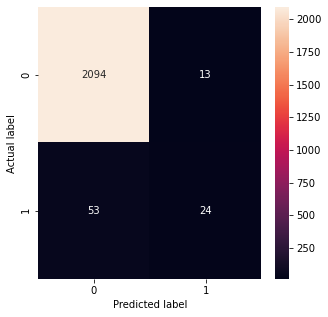

In [131]:
plot_cm(np.array(Class_labels), np.array(Issued_pred))

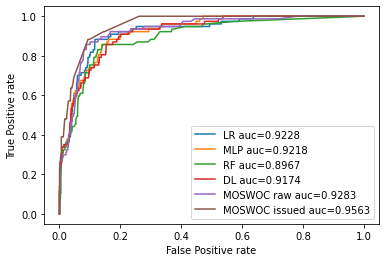

In [171]:
#Again, ROC curve if required.

plt.figure(0).clf()

fpr, tpr, thresh = roc_curve(Class_labels, Final_Log_pred)
auc = roc_auc_score(Class_labels, Final_Log_pred)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="LR auc="+str(auc))

fpr, tpr, thresh = roc_curve(Class_labels, Final_MLP_pred)
auc = roc_auc_score(Class_labels, Final_MLP_pred)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="MLP auc="+str(auc))

fpr, tpr, thresh = roc_curve(Class_labels, Final_RF_pred)
auc = roc_auc_score(Class_labels, Final_RF_pred)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="RF auc="+str(auc))

fpr, tpr, thresh = roc_curve(Class_labels, Final_TF_pred)
auc = roc_auc_score(Class_labels, Final_TF_pred)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="DL auc="+str(auc))

fpr, tpr, thresh = roc_curve(Class_labels, Raw_pred)
auc = roc_auc_score(Class_labels, Raw_pred)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="MOSWOC raw auc="+str(auc))

fpr, tpr, thresh = roc_curve(Class_labels, Issued_pred)
auc = roc_auc_score(Class_labels, Issued_pred)
auc = round(auc, 4)
plt.plot(fpr,tpr,label="MOSWOC issued auc="+str(auc))

plt.legend(loc=0)

plt.ylabel('True Positive rate')
plt.xlabel('False Positive rate')

plt.savefig('NEW_COMBINED_MA_ROC')

plt.show()

# Part 8: Other

Additional code used for plotting etc.

In [21]:
#Use sklearn functionality to rank feature importance in our random forest

importances = RF_Model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

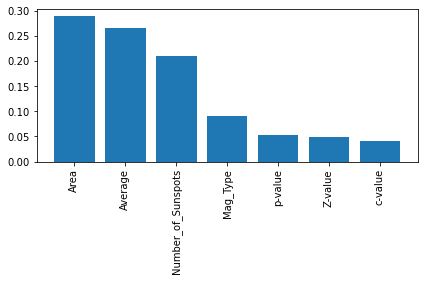

In [23]:
plt.bar(range(train_df.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(train_df.shape[1]), train_df.columns[sorted_indices], rotation=90)
plt.tight_layout()

#plt.savefig('...')

plt.show()

In [116]:
SRS_flares = SRS_day[SRS_day.Binary_Sum == 0]

In [117]:
plot_flares_df = pd.DataFrame()

plot_flares_df['Predictions'] = pd.concat([SRS_flares.Raw, SRS_flares.Issued, SRS_flares.Cumul_MLP_pos_prediction, SRS_flares.Cumul_Log_pos_prediction
                                            , SRS_flares.Cumul_RF_pos_prediction, SRS_flares.Cumul_TF_pos_prediction])

In [ ]:
plot_flares_df['Model'] = np.nan
plot_flares_df['Model'][0:2107] = 'Raw'
plot_flares_df['Model'][2107:4214] = 'Issued'
plot_flares_df['Model'][4214:6321] = 'MLP'
plot_flares_df['Model'][6321:8428] = 'Log'
plot_flares_df['Model'][8428:10535] = 'RF'
plot_flares_df['Model'][10535:12642] = 'DL'

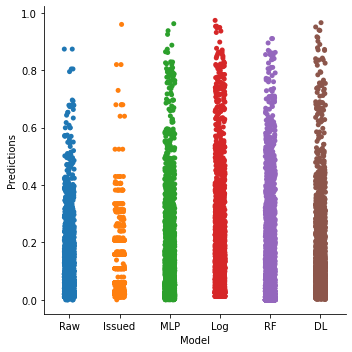

In [119]:
#sns.set(style='ticks')

catplot = sns.catplot(x='Model', y='Predictions', data=plot_flares_df)
catplot.savefig('Noflare_prediction_comparison_resampled.png')


In [ ]:
prediction_sample = SRS_flares.sample(n=8)

sample_df = pd.DataFrame()


sample_df['Predictions'] = pd.concat([prediction_sample.Raw, prediction_sample.Issued, prediction_sample.Cumul_MLP_pos_prediction, prediction_sample.Cumul_Log_pos_prediction])#, prediction_sample.Cumul_RF_pos_prediction, prediction_sample.Cumul_TF_pos_prediction])

sample_df['Model'] = np.nan
sample_df['Model'][0:8] = 'Raw'
sample_df['Model'][8:16] = 'Issued'
sample_df['Model'][16:24] = 'MLP'
sample_df['Model'][24:32] = 'Log'
#sample_df['Model'][40:50] = 'RF'
#sample_df['Model'][50:60] = 'DL'

sample_df['Index'] = np.nan
sample_df['Index'][0:8] = np.arange(1,9)
sample_df['Index'][8:16] = np.arange(1,9)
sample_df['Index'][16:24] = np.arange(1,9)
sample_df['Index'][24:32] = np.arange(1,9)
#sample_df['Index'][40:50] = np.arange(10)
#sample_df['Index'][50:60] = np.arange(10)



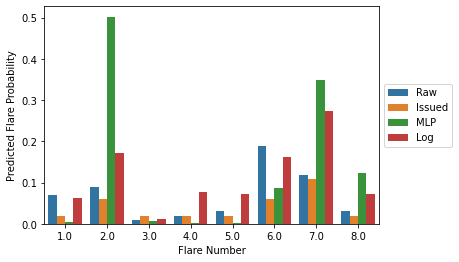

In [193]:
barplot = sns.barplot(x='Index', y='Predictions', hue='Model', data=sample_df)
barplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.xlabel('Flare Number')
plt.ylabel('Predicted Flare Probability')
barplot.figure.savefig('Sample_Comparison.png', bbox_inches='tight')




In [159]:
full_catplot_df = pd.DataFrame()

full_catplot_df['Predictions'] = pd.concat([SRS_day.Raw, SRS_day.Issued, SRS_day.Cumul_MLP_pos_prediction, SRS_day.Cumul_Log_pos_prediction
                                            , SRS_day.Cumul_RF_pos_prediction, SRS_day.Cumul_TF_pos_prediction])

In [160]:
full_catplot_df['Flare'] = pd.concat([SRS_day.Binary_Sum, SRS_day.Binary_Sum, SRS_day.Binary_Sum, SRS_day.Binary_Sum
                                            , SRS_day.Binary_Sum, SRS_day.Binary_Sum])

In [ ]:
full_catplot_df['Model'] = np.nan
full_catplot_df['Model'][0:2184] = 'Raw'
full_catplot_df['Model'][2184:4368] = 'Issued'
full_catplot_df['Model'][4368:6552] = 'MLP'
full_catplot_df['Model'][6552:8736] = 'Log'
full_catplot_df['Model'][8736:10920] = 'RF'
full_catplot_df['Model'][10920:13104] = 'DL'

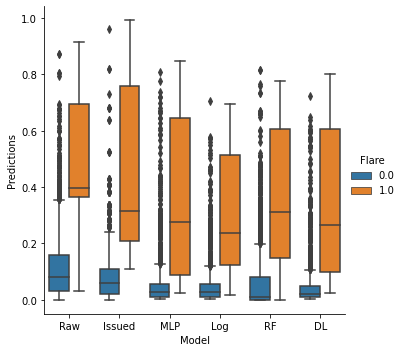

In [163]:

catplot = sns.catplot(x='Model', y='Predictions', hue='Flare', kind='box', data=full_catplot_df)
catplot.savefig('Prediction_boxplot.png')

In [198]:
SRS_df_pos = SRS_df[SRS_df.Binary_Flare == 1]
SRS_df_neg = SRS_df[SRS_df.Binary_Flare == 0]



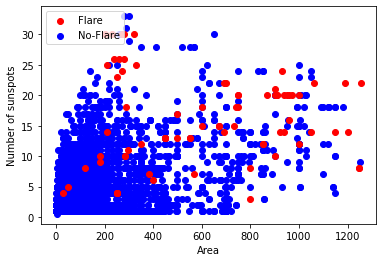

In [206]:
plt.scatter(SRS_df_pos['Area'], SRS_df_pos['NN'], color='red', label='Flare', zorder=2)
plt.scatter(SRS_df_neg['Area'], SRS_df_neg['NN'], color='blue', label='No-Flare', zorder=1)
plt.legend(loc="upper left")
plt.ylabel('Number of sunspots')
plt.xlabel('Area')

#plt.savefig('...')

plt.show()